<a href="https://colab.research.google.com/github/MalikHasnat1999/ZTM_Tensorflow/blob/master/09_Milestone_Project_2_Skimlit%F0%9F%93%84%F0%9F%94%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skimlit📄🔥

The purpose of this notebook is to build a NLP model to make reading medical abstracts easier.

The paper we are replicating is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251



# Import Libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Confirm GPU

In [ ]:
! nvidia-smi -L 

GPU 0: Tesla K80 (UUID: GPU-d9dc9a69-a102-dfb9-6647-ae26247c1d30)


# Helper Functions

In [ ]:

def evaluate_model(y_true, y_pred):
  """
  Returns:
    Model Evaluation Dictionary.
  """
  from sklearn.metrics import accuracy_score, precision_recall_fscore_support
  
  # calculate the model accuracy_score
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1,_ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {
      "accuracy": model_accuracy,
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1
  }

  return model_results

# Get the Data

Since we will be replicating the paper above (PubMed200k RCT), lets download the dataset they used.

We can do so from Authors Github repository: https://github.com/Franck-Dernoncourt/pubmed-rct.git

In [ ]:
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [ ]:
# list the pubmed-rct
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
! ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiment using the 20k dataset with numbers relplaced by "@" sign 
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
# check all the filenames in target directory
for filenames in os.listdir(data_dir):
  print(data_dir + "/" + filenames)

pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt


# Become one with the Data

> Visualize, visualize, visualize!

Lets create a function to read in the lines of the .txt doucuments

In [ ]:
def get_lines(filename):
  """
  Read file name and return the line of text as a list 
  Args:
    filename: string containg the target file
  Returns:
    A list of strin with one string per line from target filename 
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
# lets read in the training line
train_lines = get_lines(data_dir + "/train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Lets think how we want our data to look 

```
[{
  'line_number' : 0,
  'target' : 'BACKGROUND',
  'text' : 'Emotional eating is associated with overeating and the development of obesity .\n',
  'total_lines' : 11
}]
```

## i).preprocess_text_with_line_numbers()

Lets write a function that convert each of our dataset into above format

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in a filename, reads its content and sort through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentences number 
  the target line is:
  """

  input_lines = get_lines(filename) # get all lines from the filename
  abstract_lines = ""               # create an empty abstract
  abstract_samples = []             # create an empty list of abstract

  # Loop through the each line in the abastract
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""     # reset the abstract string if line is a 1D line
    elif line.isspace():     # check to see is the line is the new line
      abstract_line_split = abstract_lines.splitlines() # make a list of seprate lines at eact '\n'
      # Iterate through each line in a single abstract and count them at the same time
      for i, abstract_line in enumerate(abstract_line_split):
        line_dict = {}      # create an empty dict for each line
        target_text_split = abstract_line.split("\t") # split target and text
        line_dict["target"] = target_text_split[0]  # get target label
        line_dict["text"] = target_text_split[1].lower()   
        line_dict["line_number"] = i
        line_dict["total_lines"] = len(abstract_line_split) - 1 # cause starts at 0
        abstract_samples.append(line_dict)  

    else: # if the above conditions aren't fulfilled, the  line contains a sentence
      abstract_lines = abstract_lines + line

  return abstract_samples
      

In [ ]:
# get data from file and preprocess it 
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 498 ms, sys: 106 ms, total: 603 ms
Wall time: 606 ms


In [ ]:
test_samples

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'total_lines': 8},
 {'line_number': 1,
  'target': 'RESULTS',
  'text': 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'total_lines': 8},
 {'line_number': 2,
  'target': 'RESULTS',
  'text': 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'total_lines': 8},
 {'line_number': 3,
  'target': 'RESULTS',
  'text': 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspart

In [ ]:
# check our training samples
train_samples[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

## ii).Turn Data into DataFrames

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [ ]:
# Let's check the length of different lines

train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

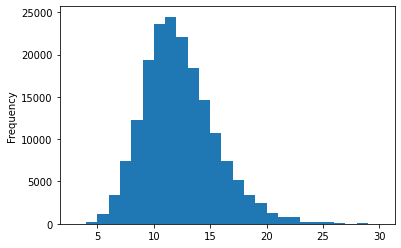

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist(bins=27)

## iii).Turn Data into Sentences

In [ ]:
train_sentences = train_df["text"].to_numpy()
val_sentences = val_df["text"].to_numpy()
test_sentences = test_df["text"].to_numpy()

In [ ]:
train_sentences[:5]

array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
       'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .'],
      dtype=object)

## iv).Make numeric labels (ML models require numeric labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
len(train_df["target"].to_numpy())

180040

Let's encode Labels


In [ ]:
# Extract labels ("target" column) and encode them to integer
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded  = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# # we can also do the above task like this

# train_labels_encoded_2 = tf.argmax(train_labels_one_hot, axis=1)
# train_labels_encoded_2

## v).Get classs names

In [ ]:
# Get classes from LabelEncoder instance
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Series of Experiments

As usual we are going to be trying out a bunch of different models and see which one works best

## Model 0 : Baseline (Naive Bayes)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create them model
model_0 = Pipeline([
          ("tf-idf", TfidfVectorizer()),
          ("NB", MultinomialNB())
])

# fit the model
model_0.fit(train_sentences,
            train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('NB',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# evaluate the model
model_0.score(val_sentences,
              val_labels_encoded)

0.7218323844829869

In [ ]:
# Make Predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
baseline_results = evaluate_model(val_labels_encoded,
                                  baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 1 : Dense model

### Preparing data for Deep Sequence model

Before we start building deeper models, we need to create Embedding and Vectorization layer

In [ ]:
# how long is each sentenecs on average
sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_sen_len = np.mean(sent_len)
avg_sen_len

26.338269273494777

(array([1.1050e+03, 3.5170e+03, 7.7850e+03, 1.3079e+04, 1.6589e+04,
        1.8463e+04, 1.8770e+04, 1.7656e+04, 1.5580e+04, 1.3302e+04,
        1.1002e+04, 9.0040e+03, 7.0390e+03, 5.5540e+03, 4.2780e+03,
        3.3890e+03, 2.7020e+03, 2.1960e+03, 1.7050e+03, 9.5300e+02,
        1.1780e+03, 9.0000e+02, 7.5000e+02, 6.0900e+02, 4.9400e+02,
        4.0100e+02, 3.5000e+02, 2.5000e+02, 2.2900e+02, 2.1500e+02,
        1.6700e+02, 1.2600e+02, 1.0200e+02, 1.0100e+02, 6.4000e+01,
        6.1000e+01, 5.5000e+01, 4.5000e+01, 4.0000e+01, 2.5000e+01,
        2.5000e+01, 2.4000e+01, 2.2000e+01, 1.4000e+01, 1.6000e+01,
        1.0000e+01, 7.0000e+00, 1.6000e+01, 7.0000e+00, 5.0000e+00,
        3.0000e+00, 5.0000e+00, 5.0000e+00, 6.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        3.0000e+00, 0.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00,
        0.0000e+00, 3.0000e+00, 2.0000e+00, 1.00

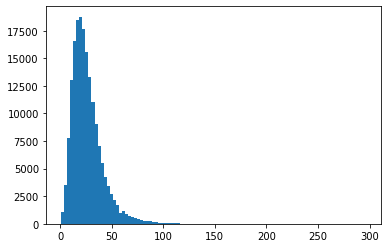

In [ ]:
# Whats the distribution looks like
plt.hist(sent_len, bins=100)

In [ ]:
# how long of a sentence covers 95% of examples
output_seq_len = int(np.percentile(sent_len, 95))
output_seq_len

55

### Vectorizer Layer

We want to make a layer which map our texts from word to numbers


In [ ]:
# how many words in out vocab? (from table-2 in pubmed200k)
max_tokens = 68000

In [ ]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,
                                                    standardize='lower_and_strip_punctuation',
                                                    split="whitespace",
                                                    ngrams=None,
                                                    output_mode='int',
                                                    output_sequence_length=output_seq_len,)

In [ ]:
# adapt the text_vectorizer layer to training data
text_vectorizer.adapt(train_sentences)

In [ ]:
# Testing our layer on random sentences
import random

target = random.choice(train_sentences)
print(f"Text:\n{target}\n")
print(f"Length of sentence: {len(target.split())}\n")
print(f"Vectorized Text:\n{text_vectorizer([target])}")

Text:
based on @ % cis , total systemic exposure to mph-mlr @mg capsule/sprinkles was similar to that for ritalin ir @mg three times daily , but marked differences in cmax values indicated that mph-mlr regimens were not bioequivalent to ritalin .

Length of sentence: 41

Vectorized Text:
[[  261    18  3040    76   670   455     6  8873    68 32280    10   150
      6    28    11 16623  1916    68   134   361   161    72  2523   102
      5  2071   334   808    28  8873   952     9    31  6830     6 16623
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# Get the config of our text_vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Embedding Layer

In [ ]:
embedding = tf.keras.layers.Embedding(input_dim=max_tokens,
                                      output_dim=128,  # Multiple of 8
                                      mask_zero=True)  

In [ ]:
# Show Example Embedding
print(f"Text:\n{target}\n")
print(f"Sentence Length: {len(target.split())}\n")
print(f"Vectorized:\n{text_vectorizer([target])}\n")
print(f"Vectorized shape: {text_vectorizer([target]).shape}\n")
print(f"Embedding\n{embedding(text_vectorizer(target))}\n")
print(f"Embedding Shape: {embedding(text_vectorizer(target)).shape}")

Text:
based on @ % cis , total systemic exposure to mph-mlr @mg capsule/sprinkles was similar to that for ritalin ir @mg three times daily , but marked differences in cmax values indicated that mph-mlr regimens were not bioequivalent to ritalin .

Sentence Length: 41

Vectorized:
[[  261    18  3040    76   670   455     6  8873    68 32280    10   150
      6    28    11 16623  1916    68   134   361   161    72  2523   102
      5  2071   334   808    28  8873   952     9    31  6830     6 16623
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Vectorized shape: (1, 55)

Embedding
[[ 0.00226709  0.00407405  0.00703359 ...  0.04091806 -0.01341343
   0.0260651 ]
 [-0.03490198  0.04285165  0.00290704 ...  0.04100286 -0.00512488
   0.00033581]
 [ 0.04239345  0.00434475  0.01111122 ...  0.03208053  0.0352968
  -0.01385866]
 ...
 [ 0.03264118  0.04377762  0.01320325 ...  0.00066014  0.01416532
   0.04348494]
 [ 0.032641

### Prefetch Dataset

We are going to setup our data to run as fast possible with `tf.data` API

Check out the tensorflow data pipeline

In [ ]:
# Turn our Data into tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# take TensorSliceDataset and turn them into prefetch dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Conv1D Model

In [ ]:
# build the model
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
vectorizer = text_vectorizer(inputs)
embed = embedding(vectorizer)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation="relu")(embed)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)

# create the model
model_1 = tf.keras.Model(inputs, outputs, name="Conv1D")

# compile the model
model_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# get model summary
model_1.summary()

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
embedding (Embedding)        (None, 55, 128)           8704000   
_________________________________________________________________
conv1d (Conv1D)              (None, 51, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,745,349
Trainable params: 8,745,349
Non-trainable params: 0
__________________________________________________

In [ ]:
# fit the model
model_1.fit(train_dataset,
            epochs=3,
            steps_per_epoch=(0.1 * len(train_dataset)),
            validation_data=val_dataset,
            validation_steps=(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 15ms/step - loss: 0.9448 - accuracy: 0.6270 - val_loss: 0.7213 - val_accuracy: 0.7230
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6872 - accuracy: 0.7432 - val_loss: 0.6641 - val_accuracy: 0.7602
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6421 - accuracy: 0.7659 - val_loss: 0.6179 - val_accuracy: 0.7740


In [ ]:
# evaluate the model
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.6186 - accuracy: 0.7791


[0.6186031699180603, 0.7791274785995483]

In [ ]:
# Make Predictions
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.24592435e-01, 1.91092059e-01, 7.41405413e-02, 2.83349782e-01,
         2.68250946e-02],
        [4.67805266e-01, 1.77618846e-01, 1.71489436e-02, 3.28688204e-01,
         8.73873755e-03],
        [1.77221373e-01, 1.53408134e-02, 4.87631653e-03, 8.02447438e-01,
         1.13980306e-04],
        ...,
        [5.67189227e-06, 1.06452662e-03, 1.12541020e-03, 6.07454649e-06,
         9.97798324e-01],
        [6.06876314e-02, 4.65370268e-01, 1.14467151e-01, 9.61458161e-02,
         2.63329089e-01],
        [2.29835957e-01, 5.13336122e-01, 1.18465416e-01, 5.91717437e-02,
         7.91908130e-02]], dtype=float32), (30212, 5))

In [ ]:
model_1_pred = tf.argmax(model_1_pred_probs, axis=1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
# use evaluation model function
model_1_results = evaluate_model(val_labels_encoded,
                                 model_1_pred) 
model_1_results

{'accuracy': 77.91274990070171,
 'f1': 0.7760064685630719,
 'precision': 0.7757649662426414,
 'recall': 0.779127499007017}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2 : Feature Extraction with Token Embedding USE

Now lets use pretrained wrod embedding from tensorflow Hub more specifically Universal Sentence Encoder https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used the GloVe but we are using the USE the later one

In [ ]:
# Create Keras Layer of use
import tensorflow_hub as hub

USE_layer = hub.KerasLayer(handle="https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           name="universal_sentence_encoder",)

In [ ]:
# Test out the pretrained embedding on a random sentence
target = random.choice(train_sentences)
print(f"Random Sentence:\n{target}\n")
print(f"Sentence After Embedding:\n{USE_layer([target])}\n")
print(f"Length of Sentence Embedding: {len(USE_layer([target]))}\n")

Random Sentence:
multidimensional evaluation of the app will also be conducted to assess usability and feasibility .

Sentence After Embedding:
[[ 0.05963954  0.00391734 -0.03644108 -0.02950873  0.04870702 -0.00387887
  -0.05362897  0.04021939  0.04336936  0.0142516   0.01427909  0.07000203
   0.03434391  0.07449558 -0.07585571 -0.01913788  0.07143342  0.04152056
  -0.0631313   0.05504093  0.08407318  0.01714429 -0.0430626   0.0345786
   0.00401454  0.084625   -0.04309194 -0.03195841 -0.03495083 -0.05517432
  -0.00644747 -0.03270973  0.06406797 -0.03811426 -0.01648764  0.04316549
  -0.06718496 -0.06167616  0.07042315  0.0151267   0.01344424 -0.01768938
  -0.0639594  -0.00824364  0.01130941  0.04219564  0.04774864  0.00878358
   0.04882371  0.02314849  0.00551716 -0.06960446 -0.01698327  0.04366244
  -0.03768395 -0.04014648 -0.01991002 -0.04339366 -0.04417389  0.04663092
   0.01464158 -0.00581259  0.01697167 -0.07990614 -0.01415283  0.04252266
  -0.03720325 -0.02080763 -0.03883657 -0.03

In [ ]:
# Build the model
inputs = tf.keras.Input(shape=[], dtype=tf.string)
x = USE_layer(inputs)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)

# create the model
model_2 = tf.keras.Model(inputs, outputs, name="pretrained_embedding")

# compile the model
model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Get model summary
model_2.summary()

Model: "pretrained_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# fit the model
model_2.fit(train_dataset,
            epochs=3,
            steps_per_epoch=(0.1 * len(train_dataset)),
            validation_data=val_dataset,
            validation_steps=(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 21ms/step - loss: 0.9144 - accuracy: 0.6498 - val_loss: 0.8034 - val_accuracy: 0.6898
Epoch 2/3
545/562 [============================>.] - ETA: 0s - loss: 0.7703 - accuracy: 0.7018

In [ ]:
# evaluate the model
model_2.evaluate(val_dataset)

In [ ]:
# Make predictions
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs[:10]

In [ ]:
model_2_pred = tf.argmax(model_2_pred_probs, axis=1)
model_2_pred

In [ ]:
# use model evaluation function
model_2_results = evaluate_model(val_labels_encoded,
                                 model_2_pred)
model_2_results

In [ ]:
baseline_results

## Model 3 : Conv1D with character embedding

The paper we are replicating states that they used combination of token and character-level embedding

Previously we have token-level embedding but we'ill need to do similar steps for characters if we want to use character level embedding

### Character-level Vectorizer

In [ ]:
# make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# text spliting non-character-level sequence into characters
split_chars(target)

'b a s e d   o n   @   %   c i s   ,   t o t a l   s y s t e m i c   e x p o s u r e   t o   m p h - m l r   @ m g   c a p s u l e / s p r i n k l e s   w a s   s i m i l a r   t o   t h a t   f o r   r i t a l i n   i r   @ m g   t h r e e   t i m e s   d a i l y   ,   b u t   m a r k e d   d i f f e r e n c e s   i n   c m a x   v a l u e s   i n d i c a t e d   t h a t   m p h - m l r   r e g i m e n s   w e r e   n o t   b i o e q u i v a l e n t   t o   r i t a l i n   .'

In [ ]:
# split sequence-level data into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# whats the average character length 
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

(array([6.7000e+02, 1.3900e+03, 4.0270e+03, 6.2540e+03, 9.7670e+03,
        1.2155e+04, 1.2906e+04, 1.5233e+04, 1.5572e+04, 1.4717e+04,
        1.3744e+04, 1.2475e+04, 1.1130e+04, 8.7230e+03, 7.8800e+03,
        6.6120e+03, 5.3430e+03, 4.2990e+03, 3.5050e+03, 2.6320e+03,
        2.2170e+03, 1.8000e+03, 1.4280e+03, 1.1320e+03, 8.7700e+02,
        6.5700e+02, 4.7400e+02, 4.6100e+02, 3.4000e+02, 3.0300e+02,
        2.4700e+02, 1.9900e+02, 1.4500e+02, 1.1100e+02, 1.0000e+02,
        8.8000e+01, 7.1000e+01, 4.8000e+01, 4.4000e+01, 3.6000e+01,
        2.9000e+01, 2.9000e+01, 1.8000e+01, 2.9000e+01, 1.3000e+01,
        1.3000e+01, 1.4000e+01, 1.0000e+01, 5.0000e+00, 7.0000e+00,
        9.0000e+00, 3.0000e+00, 5.0000e+00, 5.0000e+00, 7.0000e+00,
        2.0000e+00, 3.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.00

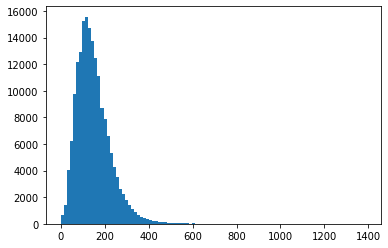

In [ ]:
# check the distribuition of our sequences at character-level
plt.hist(char_len, bins=100)

In [ ]:
# find what character length covers the 95% of characters
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# create character-level toek vectorizer
num_char_tokkens = len(alphabet)
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=num_char_tokkens,
                                                    output_sequence_length=output_seq_char_len,
                                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training data
char_vectorizer.adapt(train_chars)

In [ ]:
# check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of character {len(char_vocab)}")
print(f"5 most common character: {char_vocab[:5]}")
print(f"5 most least character: {char_vocab[-5:]}")

Number of character 28
5 most common character: ['', '[UNK]', 'e', 't', 'i']
5 most least character: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
target = random.choice(train_chars)
print(f"Text:\n{target}\n")
print(f"Length of characters: {len(target)}\n")
print(f"Vectorized characters:\n{char_vectorizer([target])}")
print(f"Length Vectorized characters: {len(char_vectorizer([target]))}")

Text:
t h i s   w i l l   b e   t h e   f i r s t   o b j e c t i v e   a n a l y s i s   o f   s u n   s a f e   b e h a v i o u r s   l e a d i n g   t o   a   p o l i c y - d r i v e n   i n t e r v e n t i o n   c o n d u c t e d   i n   a u s t r a l i a n   p r i m a r y   s c h o o l s   s i n c e   t h e   @ s   ,   a n d   w i l l   i n f o r m   t h e   f u t u r e   d i r e c t i o n   o f   s u n   s a f e t y   i n   o u r   s c h o o l s   .

Length of characters: 453

Vectorized characters:
[[ 3 13  4  9 20  4 12 12 22  2  3 13  2 17  4  8  9  3  7 22 27  2 11  3
   4 21  2  5  6  5 12 19  9  4  9  7 17  9 16  6  9  5 17  2 22  2 13  5
  21  4  7 16  8  9 12  2  5 10  4  6 18  3  7  5 14  7 12  4 11 19 10  8
   4 21  2  6  4  6  3  2  8 21  2  6  3  4  7  6 11  7  6 10 16 11  3  2
  10  4  6  5 16  9  3  8  5 12  4  5  6 14  8  4 15  5  8 19  9 11 13  7
   7 12  9  9  4  6 11  2  3 13  2  9  5  6 10 20  4 12 12  4  6 17  7  8
  15  3 13  2 17 16  3 16  8  2 10  4  8  2 1

### Character-level Embedding

In [ ]:
# create char embedding layer
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vocab), # length of vocabulary
                                       output_dim=24,  # 25 taken from research paper, used 24 multiple as of 8
                                       mask_zero=True,
                                       name="char_embed")

In [ ]:
# Test our character embedding layer
print(f"Text:\n{target}\n")
print(f"Embedding characters:\n{char_embed(char_vectorizer(target))}\n")
print(f"Embedding Shape: {char_embed(char_vectorizer(target)).shape}")

Text:
t h i s   w i l l   b e   t h e   f i r s t   o b j e c t i v e   a n a l y s i s   o f   s u n   s a f e   b e h a v i o u r s   l e a d i n g   t o   a   p o l i c y - d r i v e n   i n t e r v e n t i o n   c o n d u c t e d   i n   a u s t r a l i a n   p r i m a r y   s c h o o l s   s i n c e   t h e   @ s   ,   a n d   w i l l   i n f o r m   t h e   f u t u r e   d i r e c t i o n   o f   s u n   s a f e t y   i n   o u r   s c h o o l s   .

Embedding characters:
[[ 0.03002555 -0.03922218  0.04068146 ... -0.04444505 -0.00160142
  -0.0247511 ]
 [-0.03198107  0.03133556  0.00553123 ...  0.00135915  0.00363821
   0.03369646]
 [-0.044704   -0.01329038  0.0137086  ... -0.03408175  0.04516408
   0.01159532]
 ...
 [-0.03289469 -0.01117388 -0.04349428 ... -0.03682542  0.03859284
   0.02528704]
 [-0.03289469 -0.01117388 -0.04349428 ... -0.03682542  0.03859284
   0.02528704]
 [-0.03289469 -0.01117388 -0.04349428 ... -0.03682542  0.03859284
   0.02528704]]

Embedding Shape: (290, 2

### Prefetch character data

In [ ]:
# create char level Dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Build the Model

In [ ]:
# build the model
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)  

# create the model
model_3 = tf.keras.Model(inputs, outputs,
                         name="char-level_conv1d")

# compile the model
model_3.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# get model summary
model_3.summary()

In [ ]:
# fit the model
model_3.fit(train_char_dataset,
            epochs=3,
            steps_per_epoch=(0.1 * len(train_char_dataset)),
            validation_data=val_char_dataset,
            validation_steps=(0.1 * len(val_char_dataset)))

In [ ]:
# evaluate the model
model_3.evaluate(val_char_dataset)

In [ ]:
# make predictions
model_3_pred_probs =  model_3.predict(val_char_dataset)
model_3_pred_probs

In [ ]:
model_3_pred = tf.argmax(model_3_pred_probs, axis=1)
model_3_pred

In [ ]:
# using evaluate_model function
model_3_results = evaluate_model(val_labels_encoded,
                                 model_3_pred)
model_3_results

In [ ]:
baseline_results

## Model 4 : USE + Character Embedding (hybrid Layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create character-level model (similar to model_3 with a slight modification)
3. Combine 1 & 2 with a concatenate (`tf.layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Research Paper
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilites as output

### Model Architecture

In [ ]:
 # 1. Setup token inputs/model
 token_inputs = tf.keras.Input(shape=[], dtype=tf.string)
 token_embeddings = USE_layer(token_inputs) 
 token_output = tf.keras.layers.Dense(128, activation="relu")(token_embeddings)
 token_model = tf.keras.Model(token_inputs, token_output,
                              name="token_model")
 
 # 2. Setup char inputs/model
 char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
 char_vectors = char_vectorizer(char_inputs)
 char_embeddings = char_embed(char_vectors)
 char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings) # 50 from paper changed to 25 -> 24 Left to right and R to L
 char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. concatenate token and char model for inputs (create hybrid token embedding )
token_char_concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                           char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of Research Paper
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(5, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
# get model summary()
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           input_3[0][0]                    
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   input_2[0][0]                    
__________________________________________________________________

### Model the Plot

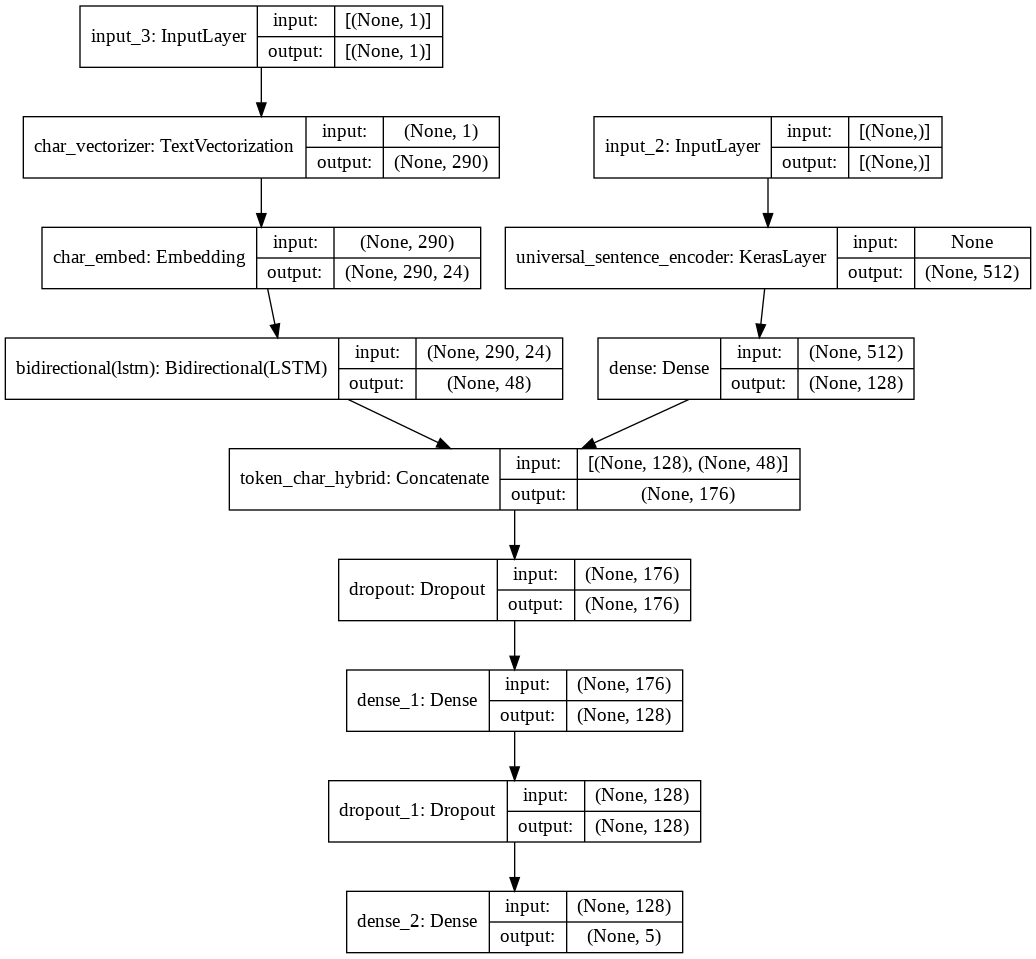

In [ ]:
# plot the model 
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [ ]:
# compile the model
model_4.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(), # Research Paper use SGD()
    metrics = ["accuracy"] 
)


### Data Pipeline for Hybrid model

Combining Token and Character data into `tf.data.Dataset`


In [ ]:
# combine chars and token into a dataset 
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # concatenate data and labels
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# same as above for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Fit the model

In [ ]:
# fit the model
model_4.fit(train_char_token_dataset,
            epochs=3,
            steps_per_epoch=(0.1 * len(train_char_token_dataset)),
            validation_data=val_char_token_dataset,
            validation_steps=(0.1 * len(val_char_token_dataset)))

In [ ]:
# evaluate the model
model_4.evaluate(val_char_token_dataset)

In [ ]:
# make predictions
model_4_pred_probs =  model_4.predict(val_char_token_dataset)
model_4_pred_probs[0]

In [ ]:
model_4_pred = tf.argmax(model_4_pred_probs, axis=1)
model_4_pred

In [ ]:
val_labels_one_hot

In [ ]:
model_4_results =  evaluate_model(val_labels_encoded,
                                  model_4_pred)
model_4_results

In [ ]:
model_1_results

## Model 5 : token embedding + character embedding + positional embedding

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


***Note:** Any engineered features used to train a model need to bbe available at test time. In our case, line number and total lines are available.

### Create positional embedding

In [ ]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

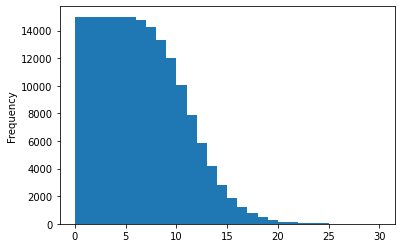

In [ ]:
train_df.line_number.plot.hist(bins=30)

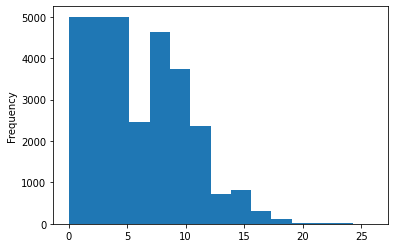

In [ ]:
val_df.line_number.plot.hist(bins=15)

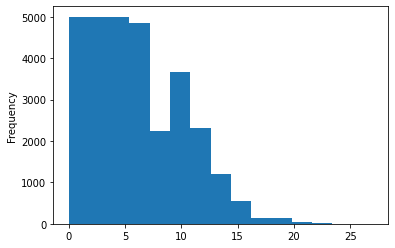

In [ ]:
test_df.line_number.plot.hist(bins=15)

In [ ]:
# One Hot the line numbers
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_number_one_hot, train_line_number_one_hot.shape

(<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

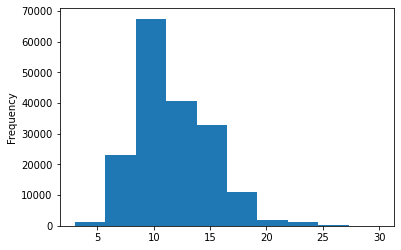

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
# how many rows covers the 95% of data
np.percentile(train_df["total_lines"], 98)

20.0

In [ ]:
# One Hot the total lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"], depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"], depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"], depth=20)

train_total_lines_one_hot, train_total_lines_one_hot.shape

(<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 20]))

### Model Architecture

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3,4,5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilites
8. Combine the inputs of 1,2,3,4 and outputs into `tf.keras.Model`

In [ ]:
# 1. USE model (token-level model)
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = USE_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs,
                             name="USE_model")

# 2. Bi-LSTM model (character-level model)
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm,
                            name="bi-LSTM model")

# 3. line_number model
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name="line_inputs")
x = tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x,
                                   name="line_number model")

# 4. total_lines model
total_lines_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = tf.keras.layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y, 
                                   name="total_lines model")

# 5. combine the outputs of 1 & 2 (hybrid embedding)
hybrid_embeddings = tf.keras.layers.Concatenate(name="token_char_hybrid_model")([token_model.output,
                                                                                 char_model.output])
# Passing inputs through the Dropout layer as per the Research paper                                                                                 
z = tf.keras.layers.Dense(32, activation="relu")(hybrid_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)

# 6. Combine the outputs of 3,4,5 (Tribrid embedding)
tribrid_embeddings = tf.keras.layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                                         total_lines_model.output,
                                                                                         z])
# 7. create output layer
output_layer = tf.keras.layers.Dense(5, activation="relu", name="output_layer")(tribrid_embeddings)                                                                                  

# 8. put togetheer model with all kinds of inputs # Order is important 
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="tribrid_embedding_model")


In [ ]:
# get model's summary
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________________

### Plot the Model


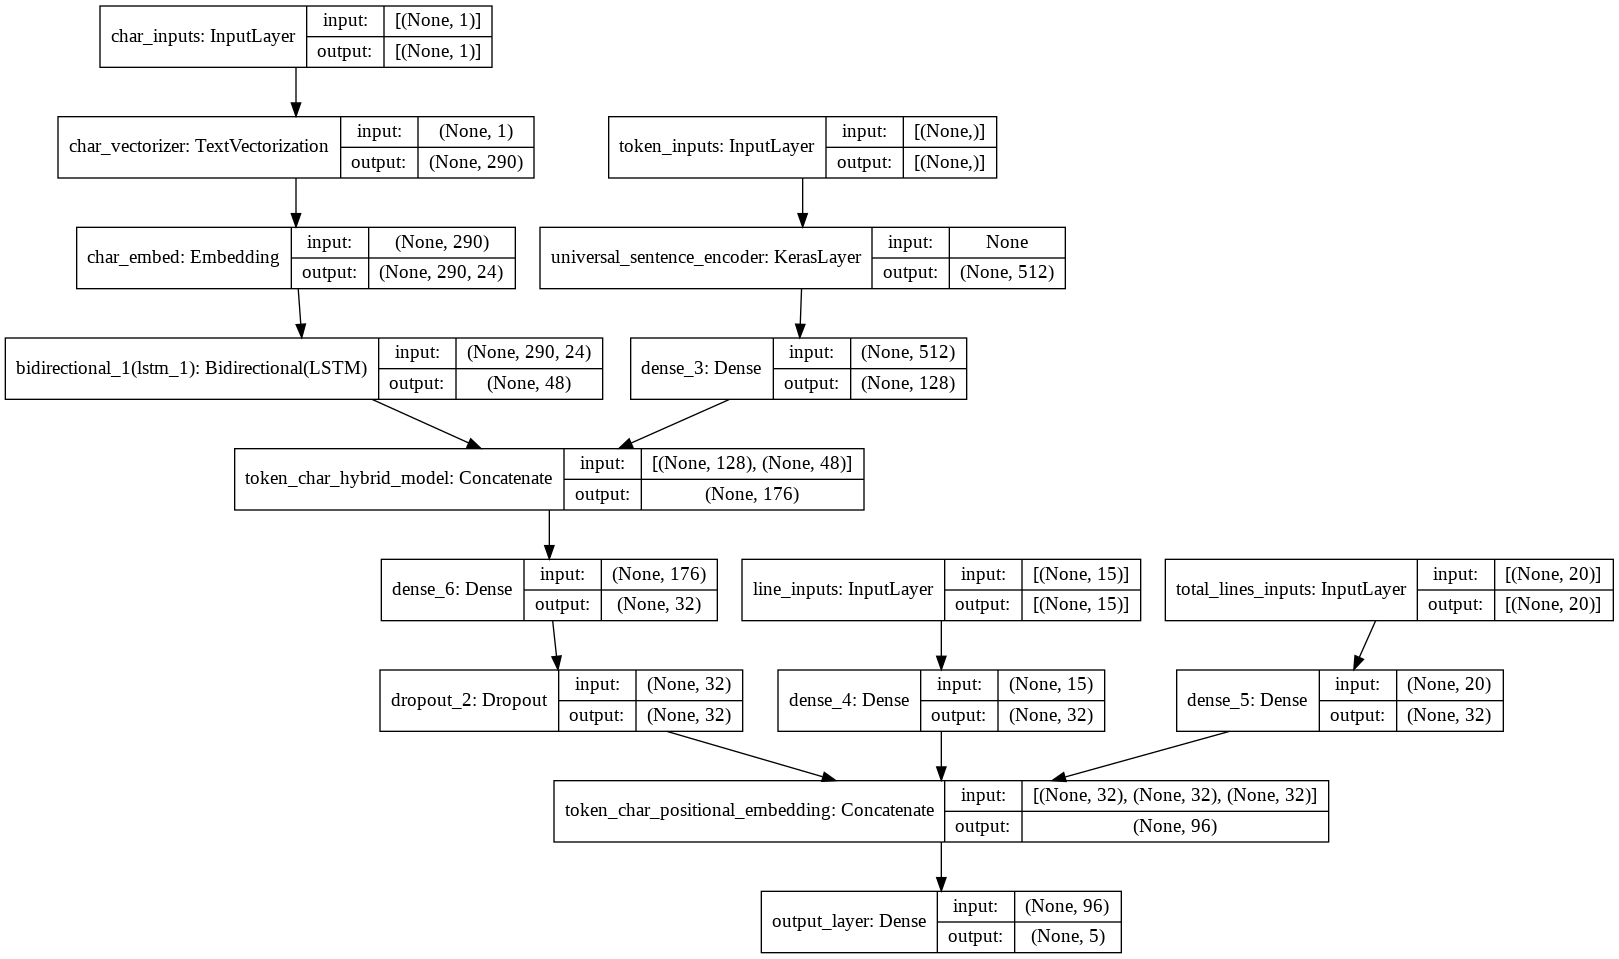

In [ ]:
tf.keras.utils.plot_model(model_5, show_shapes=True)

**What is label smoothing?**

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not considre other classes...

Really confident :`[0.0, 0.0, 1.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pre prob to to other classes, in turn hopefully improving generalization : `[0.01, 0.01, 0.96, 0.01]`

In [ ]:
# compile the model
model_5.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

### Tribrid embedding Datasets

In [ ]:
 # Train dataset
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# check char_token_pos_dataset
train_char_token_pos_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

### Fit the model

In [ ]:
# fit the model
model_5.fit(train_char_token_pos_dataset,
            epochs=3,
            steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
            validation_data=val_char_token_pos_dataset,
            validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

In [ ]:
# evaluate the model
model_5.evaluate(val_char_token_pos_dataset)

In [ ]:
# make predictions
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

In [ ]:
model_5_pred = tf.argmax(model_5_pred_probs, axis=1)
model_5_pred

In [ ]:
model_5_results = evaluate_model(val_labels_encoded,
                                 model_5_pred)
model_5_results

# Compare Model results

In [ ]:
results = pd.DataFrame({"model_0" : baseline_results,
                        "model_1" : model_1_results,
                        "model_2" : model_2_results,
                        "model_3" : model_3_results,
                        "model_4" : model_4_results,
                        "model_5" : model_5_results,
                       })
results = results.transpose()
results.head()

In [ ]:
# reduce accuracy to same scale as other metrics
results["accuracy"] = results["accuracy"]/100

In [ ]:
# plot and compare all model results
results.plot(kind="bat", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
# sort models by f1-score
results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize(10,7))

# Load tribrid model 

In [ ]:
! wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip

--2021-09-24 15:35:04--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.195.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M   188MB/s    in 4.9s    

2021-09-24 15:35:09 (187 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]



In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/skimlit_tribrid_model.zip")
zip_ref.extractall()
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/skimlit_tribrid_model.zip' mode='r'>>

In [ ]:
loaded_model = tf.keras.models.load_model("/content/skimlit_tribrid_model")

In [ ]:
loaded_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 207s 216ms/step - loss: 0.9479 - accuracy: 0.8275


[0.9478996396064758, 0.8274526596069336]

#1.Turn the test data samples into `tf.data` Datasets and then evaluate the Tribrid model on the test samples.

In [ ]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [ ]:
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_pos_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
loaded_model.evaluate(test_char_token_pos_dataset)

942/942 [==============================] - 213s 226ms/step - loss: 0.9558 - accuracy: 0.8240


[0.9558374285697937, 0.8239588737487793]

In [ ]:
# make predictions
loaded_model_pred_probs = loaded_model.predict(test_char_token_pos_dataset)
loaded_model_pred_probs

array([[0.29455352, 0.08479647, 0.04158431, 0.51307744, 0.06598823],
       [0.28619692, 0.07009872, 0.29603702, 0.3105397 , 0.03712765],
       [0.05511272, 0.02543881, 0.801705  , 0.08280668, 0.03493682],
       ...,
       [0.06925276, 0.07957347, 0.07673086, 0.04602826, 0.72841465],
       [0.06247636, 0.07749142, 0.09398694, 0.04041789, 0.72562736],
       [0.07519376, 0.47618854, 0.19286115, 0.0464907 , 0.2092658 ]],
      dtype=float32)

In [ ]:
loaded_model_pred = tf.argmax(loaded_model_pred_probs, axis=1)
loaded_model_pred

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1])>

#2.Find the most wrong predictons from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability)

In [ ]:
# make a dataframe of different parameters
df = pd.DataFrame({
    "text" : test_sentences,
    "y_true" : test_labels_encoded,
    "y_pred" : loaded_model_pred,
    "pred_probs" : loaded_model_pred_probs.max(axis=1)
})

df.head()

,text,y_true,y_pred,pred_probs
0,this study analyzed liver function abnormaliti...,0,3,0.513077
1,a post hoc analysis was conducted with the use...,4,3,0.310540
2,liver function tests ( lfts ) were measured at...,4,2,0.801705
3,survival analyses were used to assess the asso...,4,2,0.627319
4,the percentage of patients with abnormal lfts ...,4,4,0.718288


In [ ]:
# adding a column in dataframe that tells whether the predictions is true or not
df["pred_correct"] = df["y_true"] == df["y_pred"]
df.head()

,text,y_true,y_pred,pred_probs,pred_correct
0,this study analyzed liver function abnormaliti...,0,3,0.513077,False
1,a post hoc analysis was conducted with the use...,4,3,0.310540,False
2,liver function tests ( lfts ) were measured at...,4,2,0.801705,False
3,survival analyses were used to assess the asso...,4,2,0.627319,False
4,the percentage of patients with abnormal lfts ...,4,4,0.718288,True


In [ ]:
most_wrong_df = df[df["pred_correct"] == False].sort_values("pred_probs", ascending=False)
most_wrong_df.head()

,text,y_true,y_pred,pred_probs,pred_correct
16347,to evaluate the effects of the lactic acid bac...,0,3,0.944838,False
13874,symptom outcomes will be assessed and estimate...,1,2,0.941099,False
1221,data were collected prospectively for @ months...,4,2,0.928523,False
13598,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,2,4,0.918107,False
21382,"design , settings , participants , and interve...",3,2,0.918088,False


In [ ]:
len(df), len(most_wrong_df)

(30135, 5305)

In [ ]:
random.choice(most_wrong_df.to_numpy())

array(["panel inter-rater agreement and patient-panel correlation was assessed using kendall 's coefficient of concordance and spearman 's rank correlation tests respectively .",
       2, 4, 0.5267096161842346, False], dtype=object)

In [ ]:
# visulaizing the wrong samples
import random
for i in range(3):
  target = random.choice(most_wrong_df.to_numpy())
  print(f"Text:\n{target[0]}\n")
  print(f"True_label: {class_names[target[1]]}")
  print(f"Pred_label: {class_names[target[2]]}")
  print("---------------------\n")

Text:
the purpose of this study was to compare aroma-acupressure and aromatherapy with respect to their effects on agitation in patients with dementia .

True_label: BACKGROUND
Pred_label: OBJECTIVE
---------------------

Text:
after iv administration of atropine ( @ mg/kg ) , anesthesia was induced with an infusion of dexmedetomidine ( @ g/kg ) over @ minutes for group d , whereas normal saline was infused for group p. propofol ( @ mg/kg ) was then injected iv over @ to @ seconds , followed by an infusion of remifentanil ( @ g/kg ) over @ minute for both groups .

True_label: METHODS
Pred_label: RESULTS
---------------------

Text:
we hypothesise that the less invasive endoscopic step-up approach is superior to the surgical step-up approach in terms of clinical and economic outcomes .

True_label: BACKGROUND
Pred_label: CONCLUSIONS
---------------------



# 3.Make example predictions (on RCT from the wild), you can go to PubMed.find and use our model to predict on 3-4 different abstracts from the wild

#***Exercise***

## Q-1
> Train model_5 on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:


* `tf.keras.callbacks.ModelCheckpoint` to save the model's best weights only.
* `tf.keras.callbacks.EarlyStopping ` to stop the model from training once the validation loss has stopped improving for ~3 epochs.


In [ ]:
# create model checkpoint callback
file_path = "model_Checkpoints/checkpoint.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                      save_best_only=True,
                                                      save_weights_only=True)

In [ ]:
# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

In [ ]:
model_5.fit(train_char_token_pos_dataset,
            epochs=20,
            steps_per_epoch=len(train_char_token_pos_dataset),
            validation_data=val_char_token_pos_dataset,
            validation_steps=len(val_char_token_pos_dataset),
            callbacks=[model_checkpoint,
                       early_stopping])

Epoch 1/20
5627/5627 [==============================] - 730s 130ms/step - loss: 1.0643 - accuracy: 0.7379 - val_loss: 0.9810 - val_accuracy: 0.7860
Epoch 2/20
5627/5627 [==============================] - 722s 128ms/step - loss: 0.9886 - accuracy: 0.7747 - val_loss: 0.9517 - val_accuracy: 0.8029
Epoch 3/20
5627/5627 [==============================] - 725s 129ms/step - loss: 0.9626 - accuracy: 0.7956 - val_loss: 0.9369 - val_accuracy: 0.8183
Epoch 4/20
5627/5627 [==============================] - 727s 129ms/step - loss: 0.9483 - accuracy: 0.8049 - val_loss: 0.9289 - val_accuracy: 0.8219
Epoch 5/20
5627/5627 [==============================] - 721s 128ms/step - loss: 0.9358 - accuracy: 0.8125 - val_loss: 0.9300 - val_accuracy: 0.8217
Epoch 6/20
5627/5627 [==============================] - 732s 130ms/step - loss: 0.9283 - accuracy: 0.8195 - val_loss: 0.9232 - val_accuracy: 0.8247
Epoch 7/20
5627/5627 [==============================] - 740s 132ms/step - loss: 0.9173 - accuracy: 0.8296 - val_

In [ ]:
all_data_result = model_5.evaluate(val_char_token_pos_dataset)
all_data_result

945/945 [==============================] - 52s 54ms/step - loss: 0.9179 - accuracy: 0.8320


[0.9179132580757141, 0.8320204019546509]

## Q-2
>Checkout the Keras guide on using pretrained GloVe embeddings. Can you get this working with one of our models?

* Hint: You'll want to incorporate it with a custom token Embedding layer.
* It's up to you whether or not you fine-tune the GloVe embeddings or leave them frozen.

## Q-3
>Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained embedding for the TensorFlow Hub BERT PubMed expert (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?

* Note: Using the BERT PubMed expert pretrained embedding requires an extra preprocessing step for sequences (as detailed in the TensorFlow Hub guide).
* Does the BERT model beat the results mentioned in this paper?

In [ ]:
!pip3 install --quiet tensorflow-text

# Load the BERT encoder and preprocessing models
import tensorflow_hub as hub
import tensorflow_text as text # Imports TF ops for preprocessing.

bert_layer = hub.KerasLayer(handle="https://tfhub.dev/google/experts/bert/pubmed/2",
                            trainable=False,
                            name="BERT")

preprocess = hub.KerasLayer(handle="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
                            trainable=False,
                            name="preprocess")

     |████████████████████████████████| 4.4 MB 4.1 MB/s 


In [ ]:
# build the model
inputs = tf.keras.Input(shape=(), dtype=tf.string)
x = preprocess(inputs)
x = bert_layer(x) # returns a dict 
outputs = tf.keras.layers.Dense(5, activation="softmax")(x["pooled_output"]) # get pool_output from dict
# create the model
bert_model = tf.keras.Model(inputs, outputs, name="Bert_model")

# get model summary()
bert_model.summary()

Model: "Bert_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
preprocess (KerasLayer)         {'input_word_ids': ( 0           input_1[0][0]                    
__________________________________________________________________________________________________
BERT (KerasLayer)               {'pooled_output': (N 109482241   preprocess[0][0]                 
                                                                 preprocess[0][1]                 
                                                                 preprocess[0][2]                 
_________________________________________________________________________________________

In [ ]:
# compile the model 
bert_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# prefetech the training data
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
trian_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# prefetch the validation data
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
# fit the model 
bert_model.fit(train_dataset,
               epochs=3)

Epoch 1/3


ValueError: ignored

In [ ]:
train_sentences[:5]

array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
       'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .'],
      dtype=object)